<h1 align="center">Examples of Double Descent</h1>
<hr style="border:2px solid gray">

### Import python packages
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression

---
### Data set
---

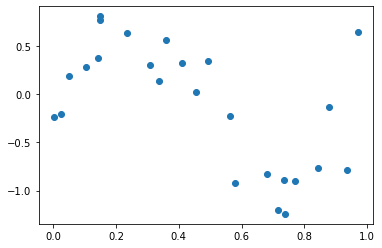

In [2]:
data = np.array([
    0.001399613, -0.23436656,
    0.971629779,  0.64689524,
    0.579119475, -0.92635765,
    0.335693937,  0.13000706,
    0.736736086, -0.89294863,
    0.492572335,  0.33854780,
    0.737133774, -1.24171910,
    0.563693769, -0.22523318,
    0.877603280, -0.12962722,
    0.141426545,  0.37632006,
    0.307203910,  0.30299077,
    0.024509308, -0.21162739,
    0.843665029, -0.76468719,
    0.771206067, -0.90455412,
    0.149670258,  0.77097952,
    0.359605608,  0.56466366,
    0.049612895,  0.18897607,
    0.409898906,  0.32531750,
    0.935457898, -0.78703491,
    0.149476207,  0.80585375,
    0.234315216,  0.62944986,
    0.455297119,  0.02353327,
    0.102696671,  0.27621694,
    0.715372314, -1.20379729,
    0.681745393, -0.83059624 ]).reshape(25,2)
y = data[:,1]
X = data[:,0:1]

plt.scatter(X[:,0], y)
plt.show()

---
### Linear regressor class
---

We use the following linear regressor class for all double descent examples. It takes only the first $p$ columns from the feature matrix $F$ and computes the minimum $\ell_2$-norm solution when $n < p$.

In [3]:
class MyRidgeRegressor:
    def __init__(self, p=3, alpha=0.0):
        self.p     = p
        self.theta = None
        self.alpha = alpha
    
    def fit(self, F, y):
        F = F[:, 0:self.p]
        self.theta = np.linalg.pinv(F.transpose()@F + self.alpha*np.identity(F.shape[1]))@F.transpose()@y

    def predict(self, F):
        F = F[:, 0:self.p]
        return F@self.theta

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"p" : self.p, "alpha" : self.alpha}

---
### Model evaluation
---

In [4]:
def evaluate_model(fg, X, y, n, ps, runs=10):
    estimator = MyRidgeRegressor()
    result = None
    for i in range(runs):
        F, y = fg(X, y, n, np.max(ps), random_state=i)

        clf = GridSearchCV(estimator=estimator,
                            param_grid=[{ 'p': list(ps) }],
                            cv=LeaveOneOut(),
                            scoring="neg_mean_squared_error")
        clf.fit(F, y)

        if result is None:
            result  = -clf.cv_results_['mean_test_score']
        else:
            result += -clf.cv_results_['mean_test_score']
    
    return result / runs

---
# 1 Random features
---

This example of double descent uses covariates generated from a multivariate normal distribution, i.e. the $j$-th column of X is given by
$$
    f_j ~ \sim ~ N(0, I_n)
$$
In order to obtain a double descent phenomenon, we need that some $f_j$ are highly correlated with $y$ and the remaining features are uncorrelated. Hence, we define $\theta_j = 1/j$ and generate observations $y$ according to the linear model
$$
    y = X \theta + \epsilon
$$
where $\epsilon \sim N(0, \sigma^2 I_n)$.

In [22]:
class RandomFeatures():
    def __init__(self, scale = 1):
        self.scale = scale

    def __call__(self, X, y, n, p, random_state=42):
        rng = default_rng(seed=random_state)
        mu = np.repeat(0, n)
        sigma = np.identity(n)
        F = rng.multivariate_normal(mu, sigma, size=p).T
        theta = np.array([ 1/(j+1) for j in range(p) ])
        y = F@theta + rng.normal(0, self.scale, size=n)
        return F, y

---
### Results
---

In [23]:
ps = range(3, 151)
scales = [0.1, 1, 10]
result = [ evaluate_model(RandomFeatures(scale=scale), None, None, 20, ps, runs=100) for scale in scales ]
result = np.array(result)

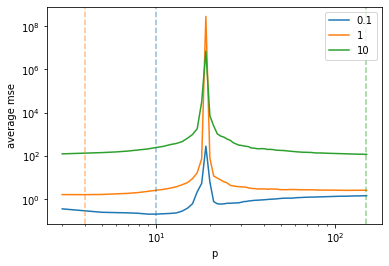

In [31]:
p = plt.plot(ps, result.T)
[ plt.axvline(x=ps[np.argmin(result[i])], color=p[i].get_color(), alpha=0.5, linestyle='--') for i in range(result.shape[0]) ]
plt.legend(scales)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("average mse")
plt.show()

---
# 2 Noisy polynomial features
---

Increasing the number of features not always leads to an increase in model complexity. There are several cases where adding more features actually constraints the model, which we call here *implicit regularization*. For instance, adding features to $F$ that are uncorrelated with $y$ will generally lead to a stronger regularization (e.g. when adding columns to $F$ that are drawn from a normal distribution). Here, we test a different strategy to increase implicit regularization. We implement a function called *compute_noisy_polynomial_features* that computes noisy polynomial features $F$ from $X = (x)$. The $j$-th column of $F \in \mathbb{R}^{n \times p}$ is given by
$$
    f_j
    =
    \begin{cases}
        (1, \dots, 1)^\top & \text{if $j = 1$}\\
        x^{k(j-2)} + \epsilon_j & \text{if $j > 1$}
    \end{cases}
$$
where $k(j) = (j\mod m) + 1$, $m \le p$ denotes the maximum degree (*max_degree* parameter) and $\epsilon_j$ is a vector of $n$ independent draws from a normal distribution with mean $\mu = 0$ and standard deviation $\sigma$. With $x^k$ we denote the $k$-th power of each element in $x$.

In [26]:
class NoisyPolynomialFeatures():
    def __init__(self, max_degree = 15, scale = 0.1):
        self.max_degree = max_degree
        self.scale      = scale

    def __call__(self, X, y, n, p, random_state=42):
        x = X if len(X.shape) == 1 else X[:,0]
        rng = default_rng(seed=random_state)
        F = np.array([]).reshape(x.shape[0], 0)
        F = np.insert(F, 0, np.repeat(1, len(x)), axis=1)
        for k in range(p):
            d = (k % self.max_degree)+1
            f = x**d + rng.normal(size=len(x), scale=self.scale)
            F = np.insert(F, k+1, f, axis=1)
        return F, y

---
### Results
---

Evaluate the performance for $p = 3, 4, \dots, 200$, and $\sigma \in \{0.01, 0.02, 0.05\}$.

In [397]:
ps = range(3, 201)
scales = [0.01, 0.02, 0.05]
result = [ evaluate_model(NoisyPolynomialFeatures(scale=scale), X, y, len(y), ps, runs=100) for scale in scales ]
result = np.array(result)

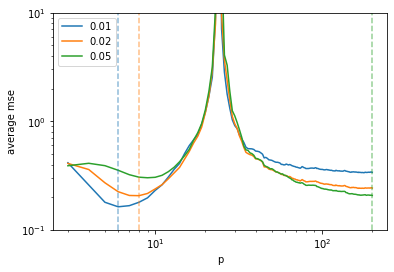

In [406]:
p = plt.plot(ps, result.T)
[ plt.axvline(x=ps[np.argmin(result[i])], color=p[i].get_color(), alpha=0.5, linestyle='--') for i in range(result.shape[0]) ]
plt.legend(scales)
plt.xscale("log")
plt.xlabel("p")
plt.yscale("log")
plt.ylim(0.1,10)
plt.ylabel("average mse")
plt.show()

---
# 3 Polynomial features combined with random features
---

Another possibility to obtain double descent curves is to start off with a standard polynomial regression task and to add random (uncorrelated) features. The $j$-th column of $F \in \mathbb{R}^{n \times p}$ is given by
$$
    f_j
    =
    \begin{cases}
        x^{j-1} & \text{if $j \le m+1$}\\
        \epsilon_j & \text{if $j > m+1$}
    \end{cases}
$$
where $m$ denotes the maximum degree of the polynomial features and $\epsilon_j ~ \sim ~ N(0, \sigma^2 I_n)$.

In [31]:
class PolynomialWithRandomFeatures():
    def __init__(self, max_degree = 15, scale = 0.1):
        self.max_degree = max_degree
        self.scale      = scale

    def __call__(self, X, y, n, p, random_state=42):
        x = X if len(X.shape) == 1 else X[:,0]
        rng = default_rng(seed=random_state)
        F = np.array([]).reshape(x.shape[0], 0)
        # Generate polynomial features
        for deg in range(np.min([p, self.max_degree+1])):
            F = np.insert(F, deg, x**deg, axis=1)
        if p <= self.max_degree+1:
            return F, y
        # Generate random features
        for j in range(p - self.max_degree - 1):
            f = rng.normal(size=F.shape[0], scale=self.scale)
            F = np.insert(F, F.shape[1], f, axis=1)
        return F, y

---
### Results
---

In [61]:
ps = list(range(3, 20)) + [30, 50, 100, 150, 200, 300, 400, 500, 1000]
scales = [0.01, 0.1, 1.0]
result = [ evaluate_model(PolynomialWithRandomFeatures(scale=scale), X, y, len(y), ps, runs=100) for scale in scales ]
result = np.array(result)

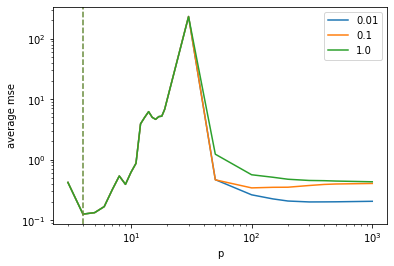

In [62]:
p = plt.plot(ps, result.T)
[ plt.axvline(x=ps[np.argmin(result[i])], color=p[i].get_color(), alpha=0.5, linestyle='--') for i in range(result.shape[0]) ]
plt.legend(scales)
plt.xscale("log")
plt.xlabel("p")
plt.yscale("log")
#plt.ylim(0.1,10)
plt.ylabel("average mse")
plt.show()

---
# 4 Legendre polynomial
---

In [6]:
class LegendrePolynomialFeatures():
    def __call__(self, X, y, n, p, random_state=42):
        x = X if len(X.shape) == 1 else X[:,0]
        F = np.array([]).reshape(x.shape[0], 0)
        # Generate polynomial features
        for deg in range(p):
            l = np.polynomial.legendre.Legendre([0]*deg + [1], domain=[0,1])
            F = np.insert(F, deg, l(x), axis=1)
        return F, y

---
### Demonstration
---

In [101]:
F, _ = LegendrePolynomialFeatures()(X, y, len(y), 1000)
g = np.linspace(0, 1, 10000)
G, _ = LegendrePolynomialFeatures()(g, y, len(y), 1000)

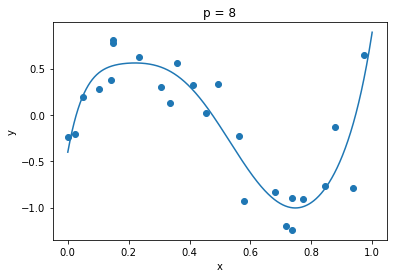

In [107]:
clf = MyRidgeRegressor(p=8)
clf.fit(F, y)
plt.plot(g, clf.predict(G))
plt.scatter(X, y)
plt.title("p = 8")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

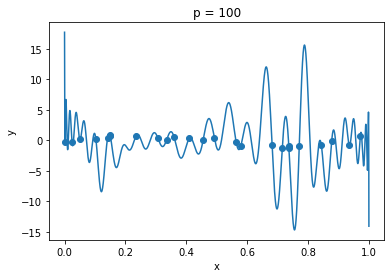

In [114]:
clf = MyRidgeRegressor(p=50)
clf.fit(F, y)
plt.plot(g, clf.predict(G))
plt.scatter(X, y)
plt.title("p = 100")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

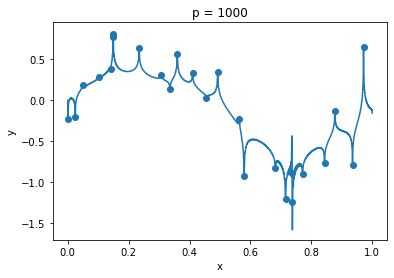

In [108]:
clf = MyRidgeRegressor(p=1000)
clf.fit(F, y)
plt.plot(g, clf.predict(G))
plt.scatter(X, y)
plt.title("p = 1000")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

---
### Results
---

In [115]:
ps = list(range(3, 20)) + [30, 50, 100, 150, 200, 300, 400, 500, 1000]
result = evaluate_model(LegendrePolynomialFeatures(), X, y, len(y), ps, runs=1)

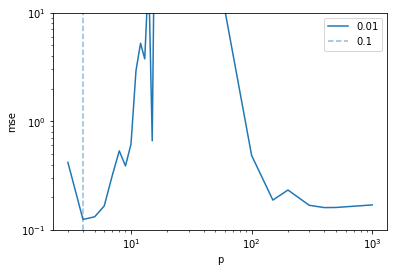

In [119]:
p = plt.plot(ps, result)
plt.axvline(x=ps[np.argmin(result)], color=p[0].get_color(), alpha=0.5, linestyle='--')
plt.legend(scales)
plt.xscale("log")
plt.xlabel("p")
plt.yscale("log")
plt.ylim(0.1,10)
plt.ylabel("mse")
plt.show()

---
### Correlation analysis
---

To understand why we are seeing a double descent curve for Legendre polynomials, we compute the correlation between features $f_j$ and response $y$:

In [10]:
cor = []
for i in range(F.shape[1]):
    cor.append(np.abs(np.correlate(F[:,i], y)))

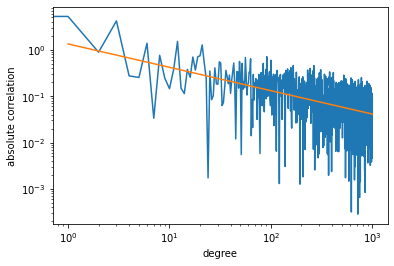

In [38]:
cor_x = np.log(list(range(1, len(cor)+1)))
cor_x = np.array(cor_x).reshape(-1, 1)
cor_y = np.log(cor)
cor_z = np.linspace(1, len(cor), 100).reshape(-1, 1)

clf = LinearRegression()
clf.fit(cor_x, cor_y)

plt.plot(cor)
plt.plot(cor_z, np.exp(clf.predict(np.log(cor_z))))
plt.xscale('log')
plt.xlabel('degree')
plt.yscale('log')
plt.ylabel('absolute correlation')
plt.show()